In [27]:
%load_ext autoreload
%autoreload 2

from model_utils import load_model
from DisruptionPredictors import DisruptionPredictorSM, DisruptionPredictorRF, DisruptionPredictorKM
from Experiments import Experiment
from plot_experiments import *

device = 'cmod'
#dataset_path = 'no_ufo_flattop_1452_shots_50%_disruptive'
#dataset_path = 'random_flattop_256_shots_60%_disruptive'
dataset_path = 'no_ufo_flattop_7736_shots_6%_disruptive'
stack_dataset_path = 'no_ufo_flattop_7736_shots_6%_disruptive/stack_4'

# Load models and create disruption predictors

cph_model, cph_features = load_model('cph', device, dataset_path)
cph_predictor = DisruptionPredictorSM("Cox Proportional Hazards", cph_model, cph_features)
cph_experiment = Experiment(device, dataset_path, cph_predictor, 'CPH')

cph_stack_model, cph_stack_features = load_model('cph', device, stack_dataset_path)
cph_stack_predictor = DisruptionPredictorSM("Cox Proportional Hazards", cph_stack_model, cph_stack_features)
cph_stack_experiment = Experiment(device, stack_dataset_path, cph_stack_predictor, 'CPH stack')

#dcph_model, dcph_features = load_model('dcph', device, dataset_path)
#dcph_predictor = DisruptionPredictorSM("Deep Cox Proportional Hazards", dcph_model, dcph_features)

#dcm_model, dcm_transformer, dcm_features = load_model('dcm', device, dataset_path)
#dcm_predictor = DisruptionPredictorSM("Deep Cox Mixture", dcm_model, dcm_features, dcm_transformer)

dsm_model, dsm_features = load_model('dsm', device, dataset_path)
dsm_predictor = DisruptionPredictorSM("Deep Survival Machines", dsm_model, dsm_features)
dsm_experiment = Experiment(device, dataset_path, dsm_predictor, 'DSM')

dsm_stack_model, dsm_stack_features = load_model('dsm', device, stack_dataset_path)
dsm_stack_predictor = DisruptionPredictorSM("Deep Survival Machines", dsm_stack_model, dsm_stack_features)
dsm_stack_experiment = Experiment(device, stack_dataset_path, dsm_stack_predictor, 'DSM stack')

rf_model, rf_features = load_model('rf', device, dataset_path)
rf_predictor = DisruptionPredictorRF("Random Forest", rf_model, rf_features)
rf_experiment = Experiment(device, dataset_path, rf_predictor, 'RF')

rf_stack_model, rf_stack_features = load_model('rf', device, stack_dataset_path)
rf_stack_predictor = DisruptionPredictorRF("Random Forest", rf_stack_model, rf_stack_features)
rf_stack_experiment = Experiment(device, stack_dataset_path, rf_stack_predictor, 'RF stack')

#km_model, km_features = rf_model, rf_features
#km_predictor = DisruptionPredictorKM("Kaplan-Meier", km_model, km_features)
#km_experiment = Experiment(device, dataset_path, km_predictor, 'KM')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loaded model from models/cmod/no_ufo_flattop_7736_shots_6%_disruptive/cph.pkl
Loaded model from models/cmod/no_ufo_flattop_7736_shots_6%_disruptive/stack_4/cph.pkl
Loaded model from models/cmod/no_ufo_flattop_7736_shots_6%_disruptive/dsm.pkl
Loaded model from models/cmod/no_ufo_flattop_7736_shots_6%_disruptive/stack_4/dsm.pkl
Loaded model from models/cmod/no_ufo_flattop_7736_shots_6%_disruptive/rf.pkl
Loaded model from models/cmod/no_ufo_flattop_7736_shots_6%_disruptive/stack_4/rf.pkl


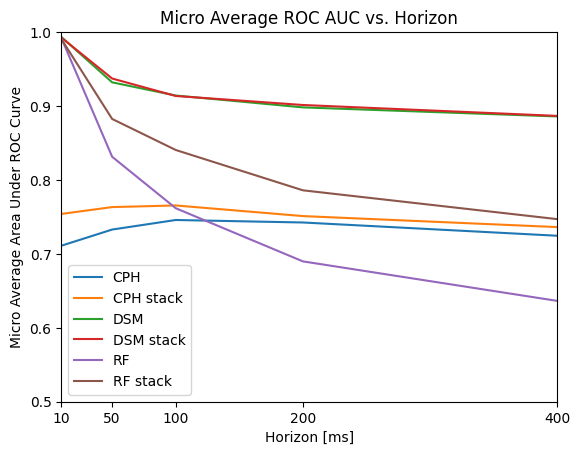

In [29]:
# Run the experiments
#core_experiment_list = [cph_experiment, dcph_experiment, dcm_experiment, dsm_experiment, dprf_experiment, km_experiment]

stack_experiment_list = [cph_experiment, cph_stack_experiment, 
                         dsm_experiment, dsm_stack_experiment,
                         rf_experiment, rf_stack_experiment]


#core_experiment_list = [dprf_experiment_50_ms, dprf_experiment_100_ms, dprf_experiment_150_ms, dprf_experiment_400_ms]

experiment_list = stack_experiment_list
#experiment_list = [cph_experiment, dsm_experiment]

plot_roc_auc_vs_horizon_micro(experiment_list)

In [26]:
#plot_brier_score_vs_horizon(experiment_list)

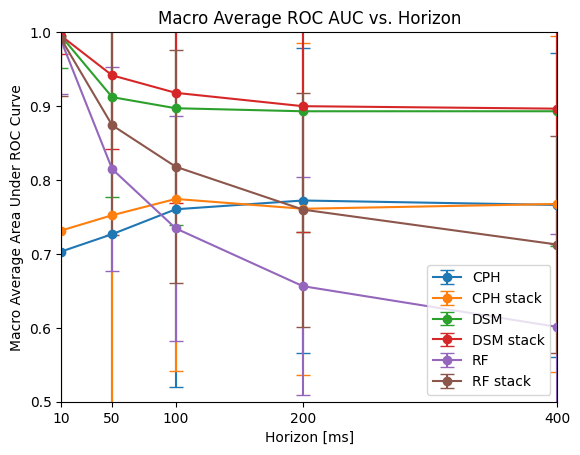

In [3]:
plot_roc_auc_vs_horizon_macro(experiment_list)

c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\plot_experiments.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(1-plt.gca().get_yticks())
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\plot_experiments.py:72: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0, 1])
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\plot_experiments.py:73: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([-5, 0])


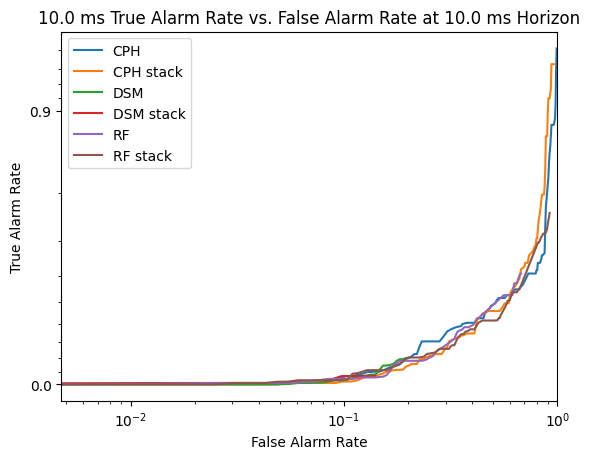

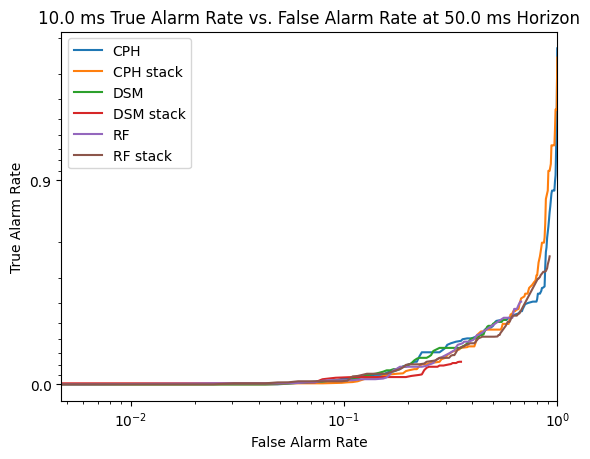

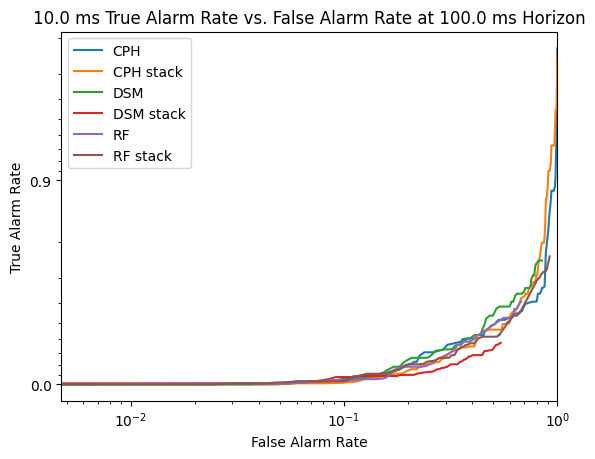

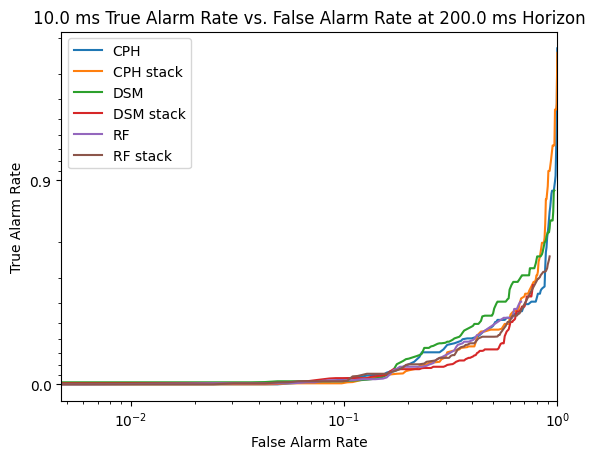

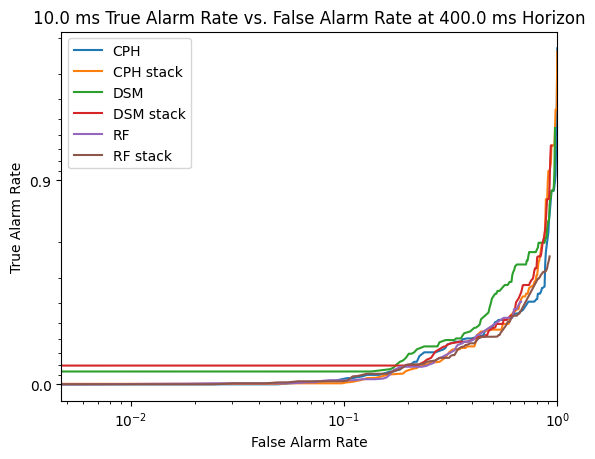

In [4]:
plot_TAR_vs_FAR(experiment_list, horizon=0.01, required_warning_time=0.01)
plot_TAR_vs_FAR(experiment_list, horizon=0.05, required_warning_time=0.01)
plot_TAR_vs_FAR(experiment_list, horizon=0.1, required_warning_time=0.01)
plot_TAR_vs_FAR(experiment_list, horizon=0.2, required_warning_time=0.01)
plot_TAR_vs_FAR(experiment_list, horizon=0.4, required_warning_time=0.01)

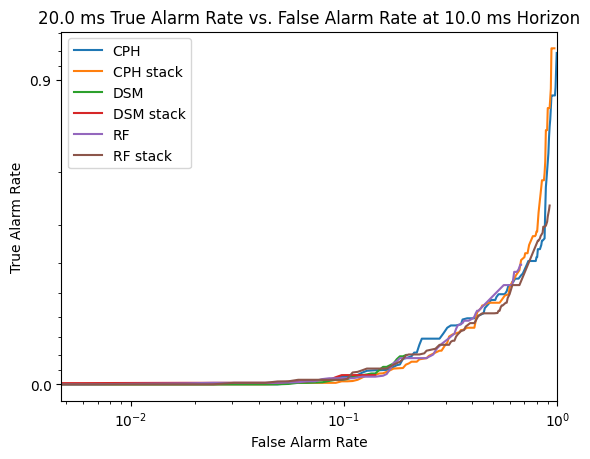

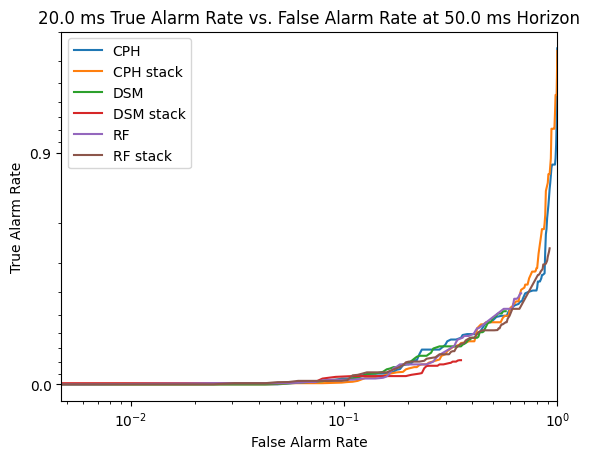

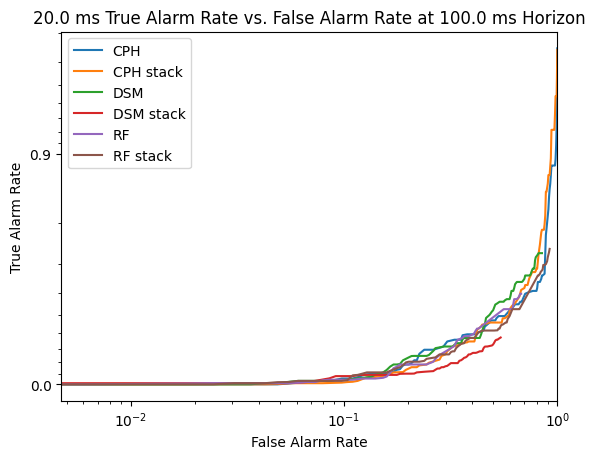

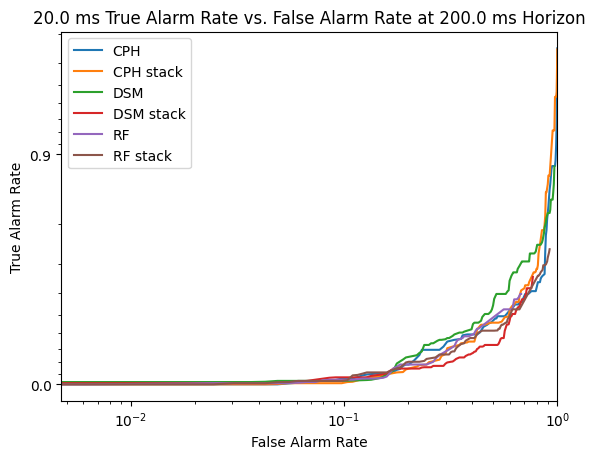

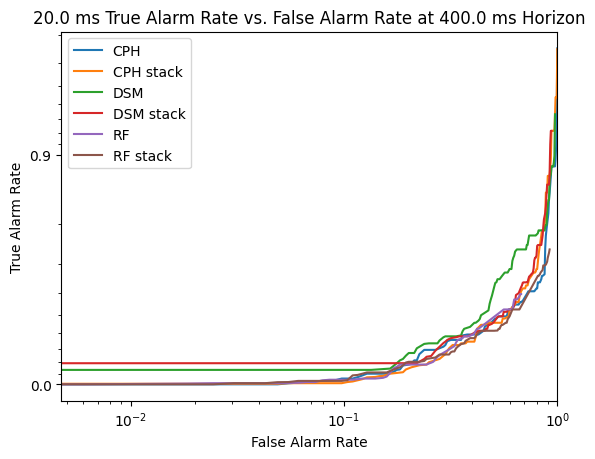

In [5]:
plot_TAR_vs_FAR(experiment_list, horizon=0.01, required_warning_time=0.02)
plot_TAR_vs_FAR(experiment_list, horizon=0.05, required_warning_time=0.02)
plot_TAR_vs_FAR(experiment_list, horizon=0.1, required_warning_time=0.02)
plot_TAR_vs_FAR(experiment_list, horizon=0.2, required_warning_time=0.02)
plot_TAR_vs_FAR(experiment_list, horizon=0.4, required_warning_time=0.02)

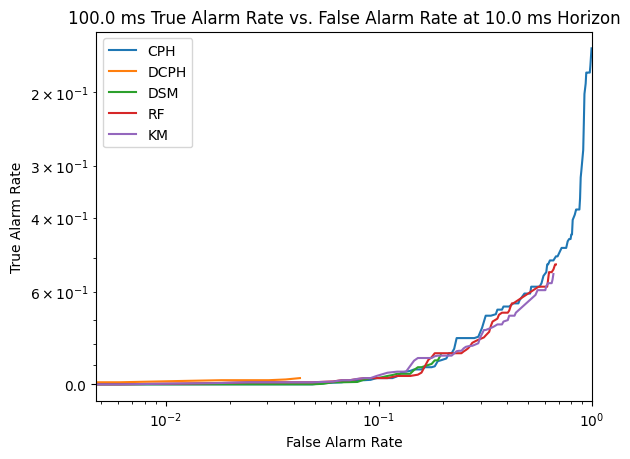

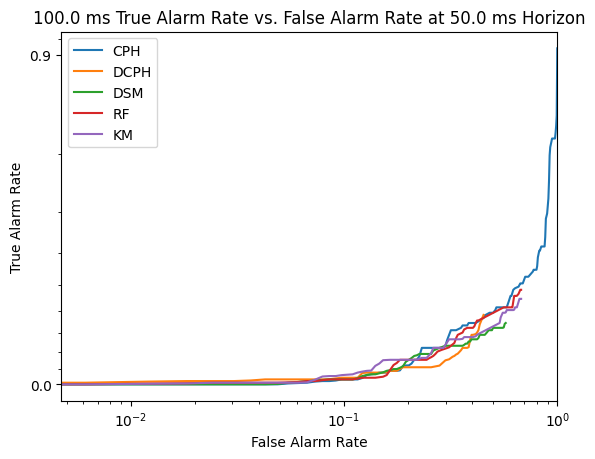

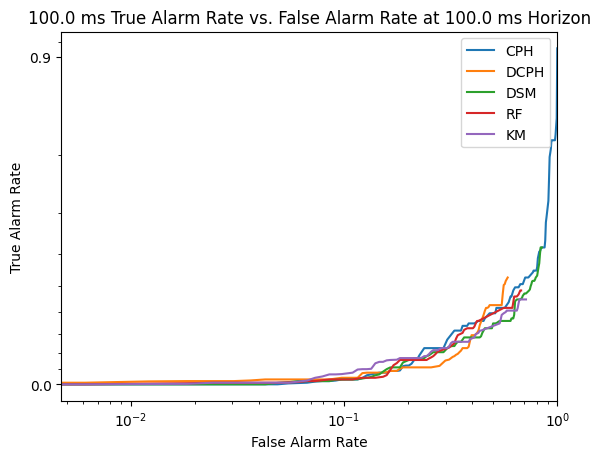

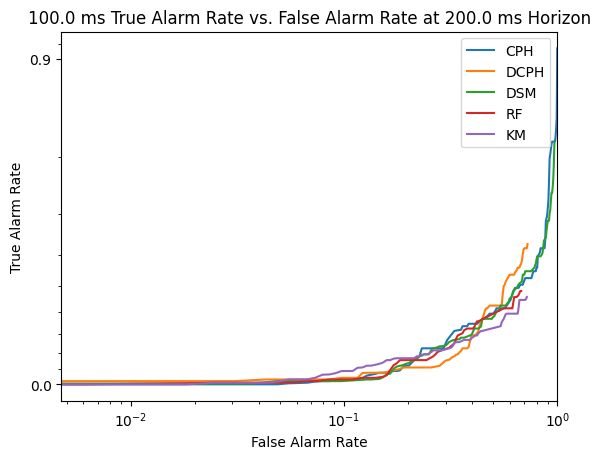

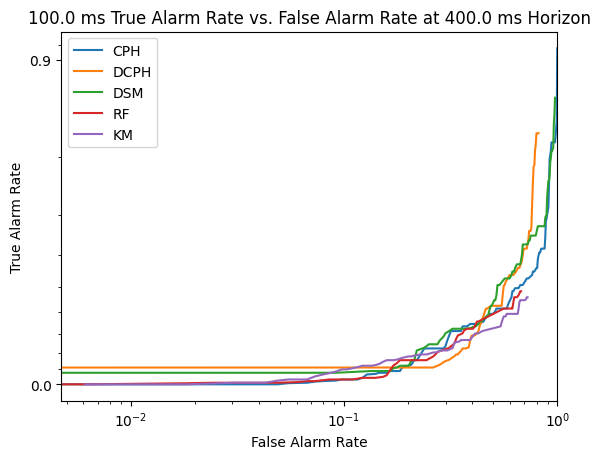

In [63]:
plot_TAR_vs_FAR(experiment_list, horizon=0.01, required_warning_time=0.1)
plot_TAR_vs_FAR(experiment_list, horizon=0.05, required_warning_time=0.1)
plot_TAR_vs_FAR(experiment_list, horizon=0.1, required_warning_time=0.1)
plot_TAR_vs_FAR(experiment_list, horizon=0.2, required_warning_time=0.1)
plot_TAR_vs_FAR(experiment_list, horizon=0.4, required_warning_time=0.1)

c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\plot_experiments.py:109: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0, 1])


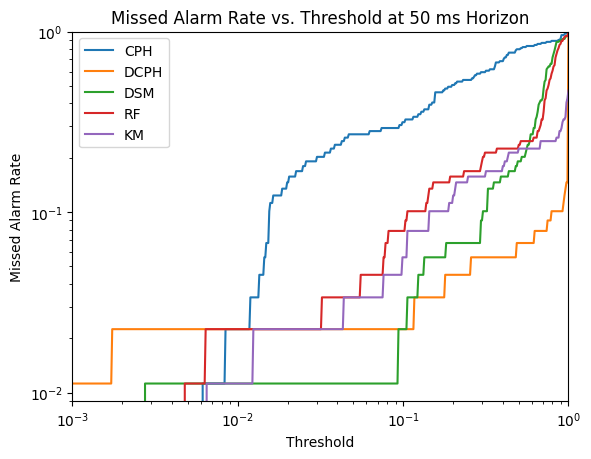

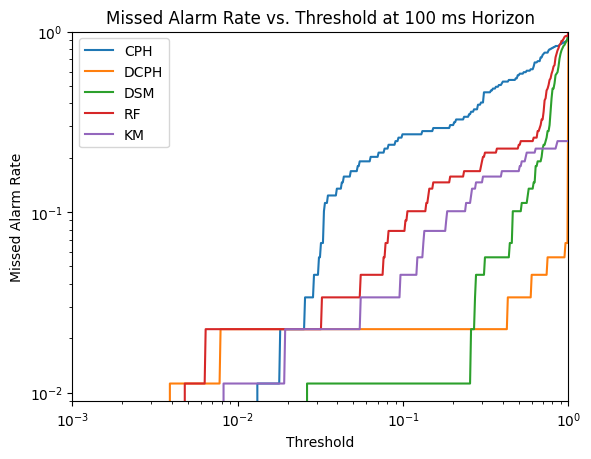

c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\plot_experiments.py:109: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0, 1])


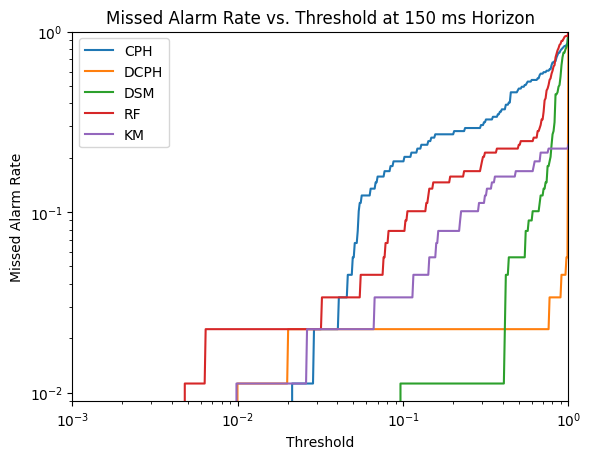

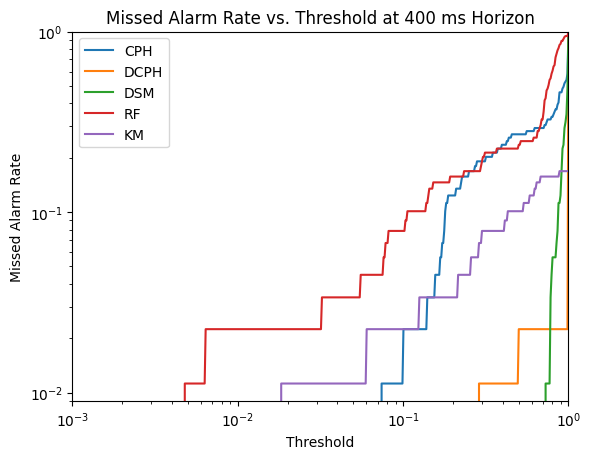

In [15]:
plot_missed_alarm_rate_vs_threshold(experiment_list, horizon=0.05)
plot_missed_alarm_rate_vs_threshold(experiment_list, horizon=0.1)
plot_missed_alarm_rate_vs_threshold(experiment_list, horizon=0.15)
plot_missed_alarm_rate_vs_threshold(experiment_list, horizon=0.4)

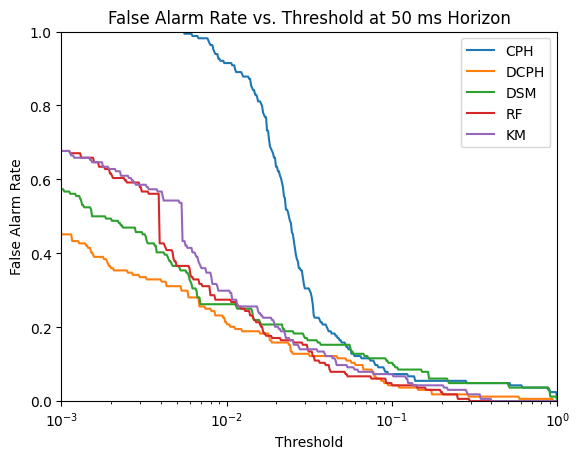

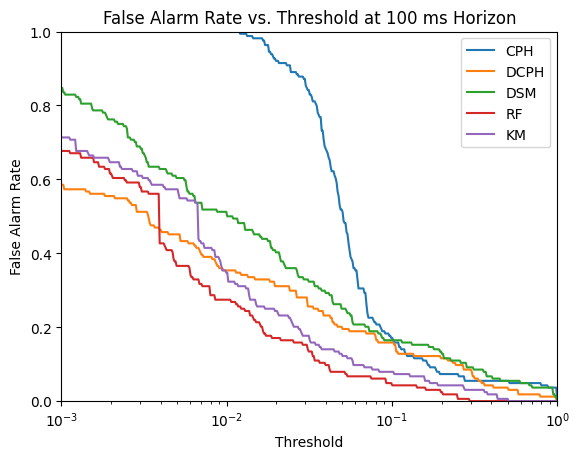

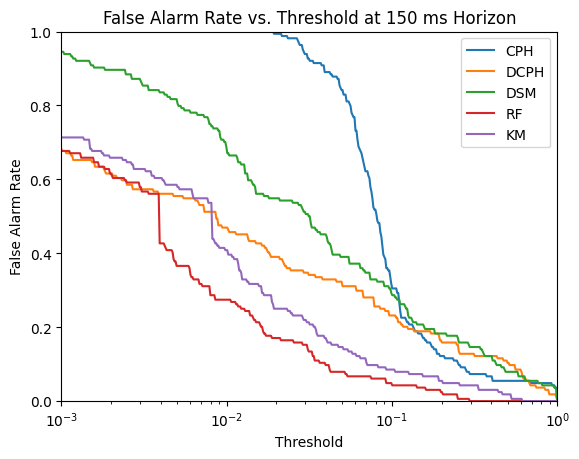

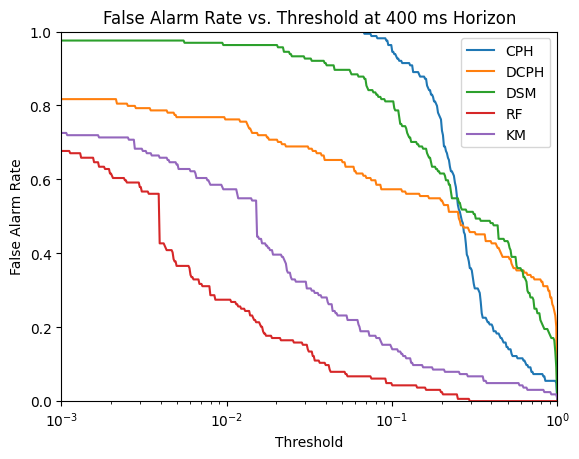

In [16]:
plot_FAR_vs_threshold(core_experiment_list, horizon=0.05)
plot_FAR_vs_threshold(core_experiment_list, horizon=0.1)
plot_FAR_vs_threshold(core_experiment_list, horizon=0.15)
plot_FAR_vs_threshold(core_experiment_list, horizon=0.4)

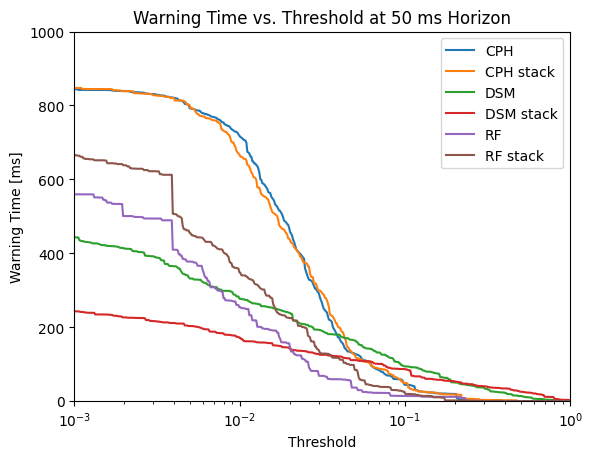

In [30]:
plot_warning_time_vs_threshold(experiment_list, 0.05)

In [33]:
#plot_warning_time_vs_TAR(experiment_list, 0.05, 0.02)
plot_warning_time_vs_FAR(experiment_list, 0.05, 0.02)

TypeError: Experiment.false_alarm_rate_vs_threshold() missing 1 required positional argument: 'required_warning_time'

<Figure size 640x480 with 0 Axes>

c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\Experiments.py:393: RuntimeWarning: invalid value encountered in divide
  threshold_precisions = np.sum(true_alarms, axis=0) / (np.sum(true_alarms, axis=0) + np.sum(false_alarms, axis=0))
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\.venv\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\zkeith\Documents\Risk-Aware Frameworks\di

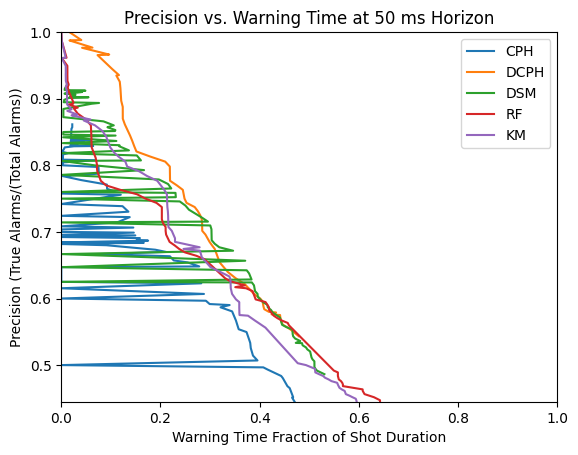

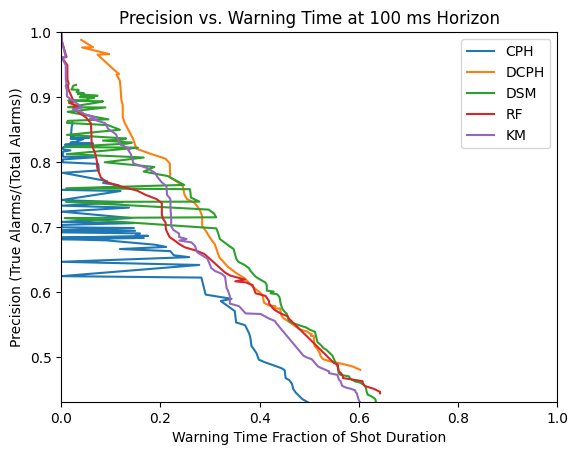

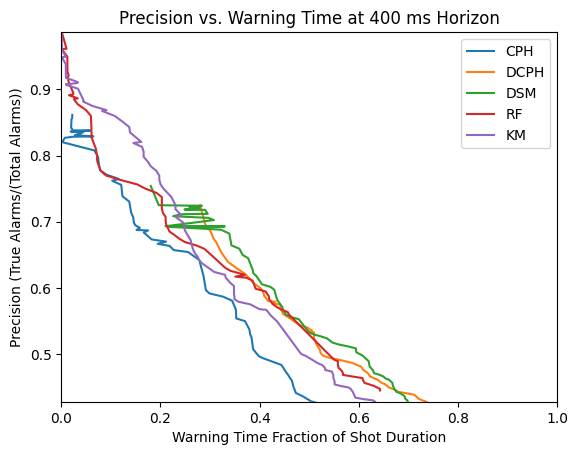

In [19]:
plot_warning_time_vs_precision(core_experiment_list, 0.05, scaled=True)
plot_warning_time_vs_precision(core_experiment_list, 0.1, scaled=True)
plot_warning_time_vs_precision(core_experiment_list, 0.4, scaled=True)

c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\plot_experiments.py:277: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([min_missed_alarm_rate, max_missed_alarm_rate])


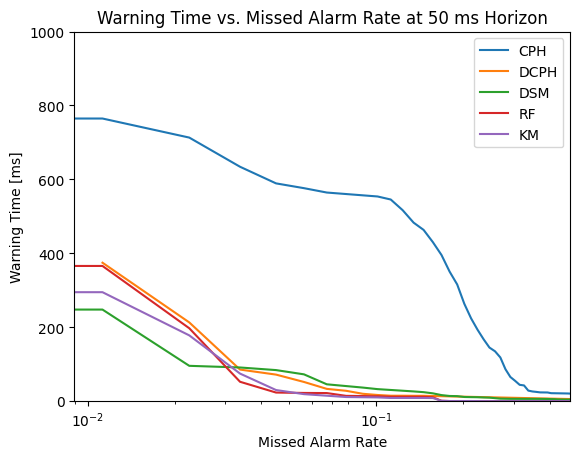

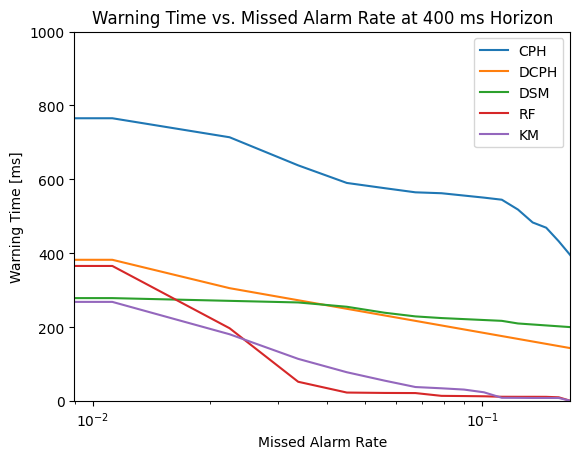

In [20]:
plot_warning_time_vs_missed_alarm_rate(core_experiment_list, 0.05)
plot_warning_time_vs_missed_alarm_rate(core_experiment_list, 0.4)

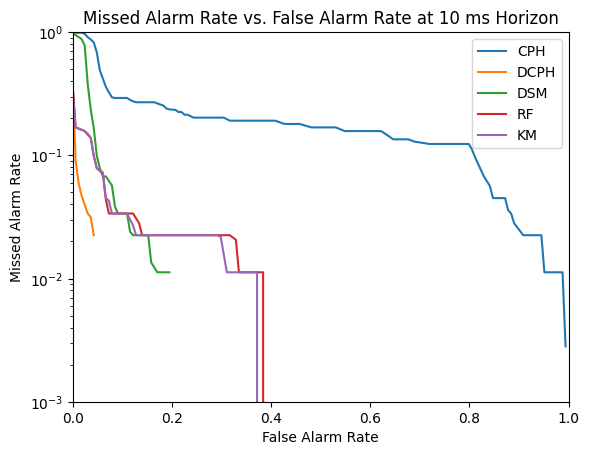

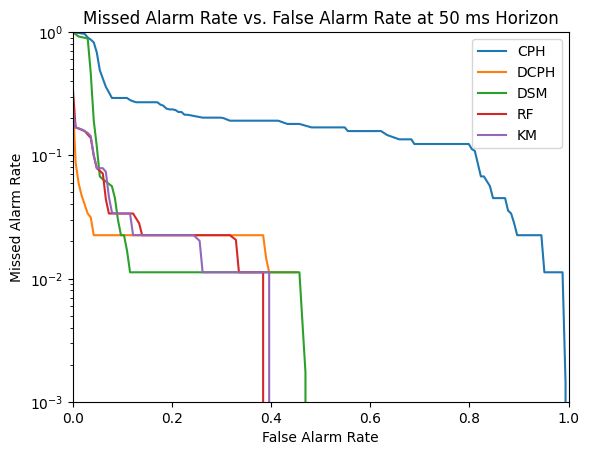

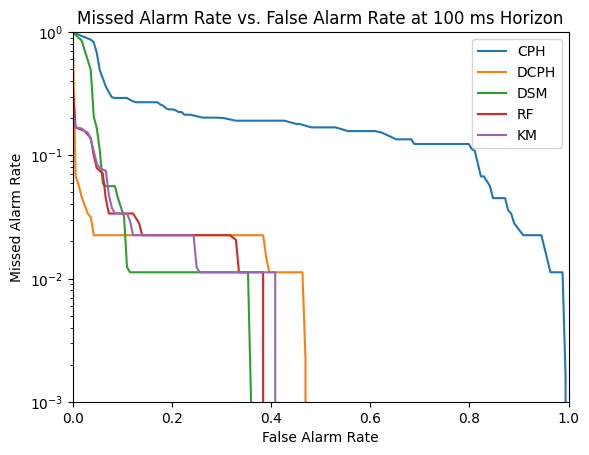

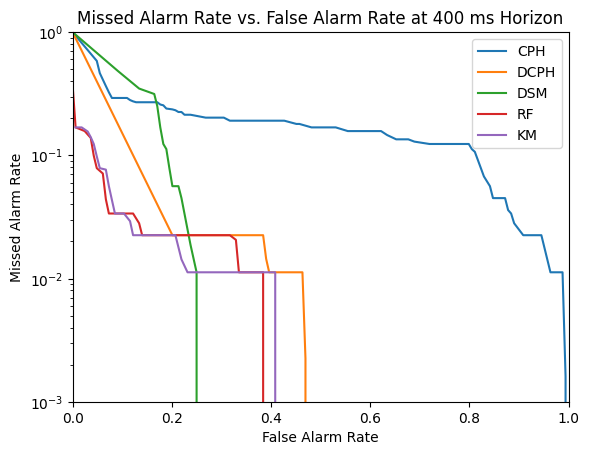

In [21]:
plot_missed_alarm_rate_vs_false_alarm_rate(core_experiment_list, 0.01)
plot_missed_alarm_rate_vs_false_alarm_rate(core_experiment_list, 0.05)
plot_missed_alarm_rate_vs_false_alarm_rate(core_experiment_list, 0.1)
plot_missed_alarm_rate_vs_false_alarm_rate(core_experiment_list, 0.4)

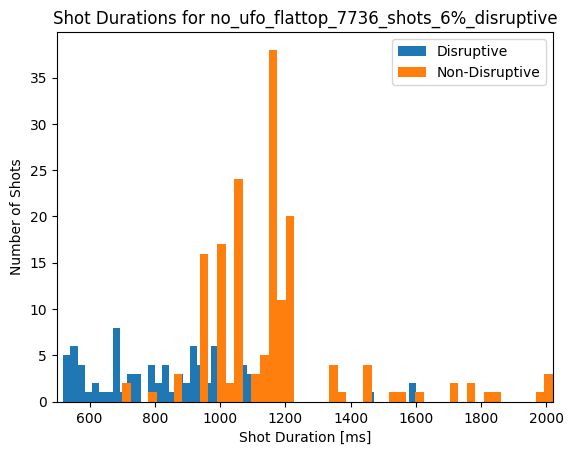

In [22]:
plot_disruptive_vs_non_disruptive_shot_durations(core_experiment_list[0])